In [10]:
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision import transforms

In [ ]:
from UNetV1 import UNetV1
from CTSinogramDataset import CTSinogramDataset 

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [14]:
transform = transforms.Compose([transforms.Normalize((0.5,), (0.5,))])

dataset = CTSinogramDataset(
    image_dirs=[
        "../../data/images/large_covid_ct_128",
    ],
    sinogram_dirs=[
        "../../data/sinograms/large_covid_ct_128",
    ],
    transform=transform,
)

print(f"Dataset size: {len(dataset)}")

Dataset size: 16235


In [15]:
dataloader = DataLoader(
    dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True
)

In [16]:
model = UNetV1().to(device)
model

UNetV1(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (up2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (dec2): Sequential(
    (0): Conv2d(256,

In [17]:
criterion = nn.MSELoss()

In [18]:
model_path = "../../models/128x128_2807_simple_unet.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Test on the test dataset
with torch.no_grad():
    test_loss = 0.0
    for sino, img in dataloader:
        sino = sino.to(device, non_blocking=True)
        img = img.to(device, non_blocking=True)

        output = model(sino)
        loss = criterion(output, img)
        test_loss += loss.item()
    print(f"Test Loss: {test_loss / len(dataloader):.4f}")

Test Loss: 0.0379


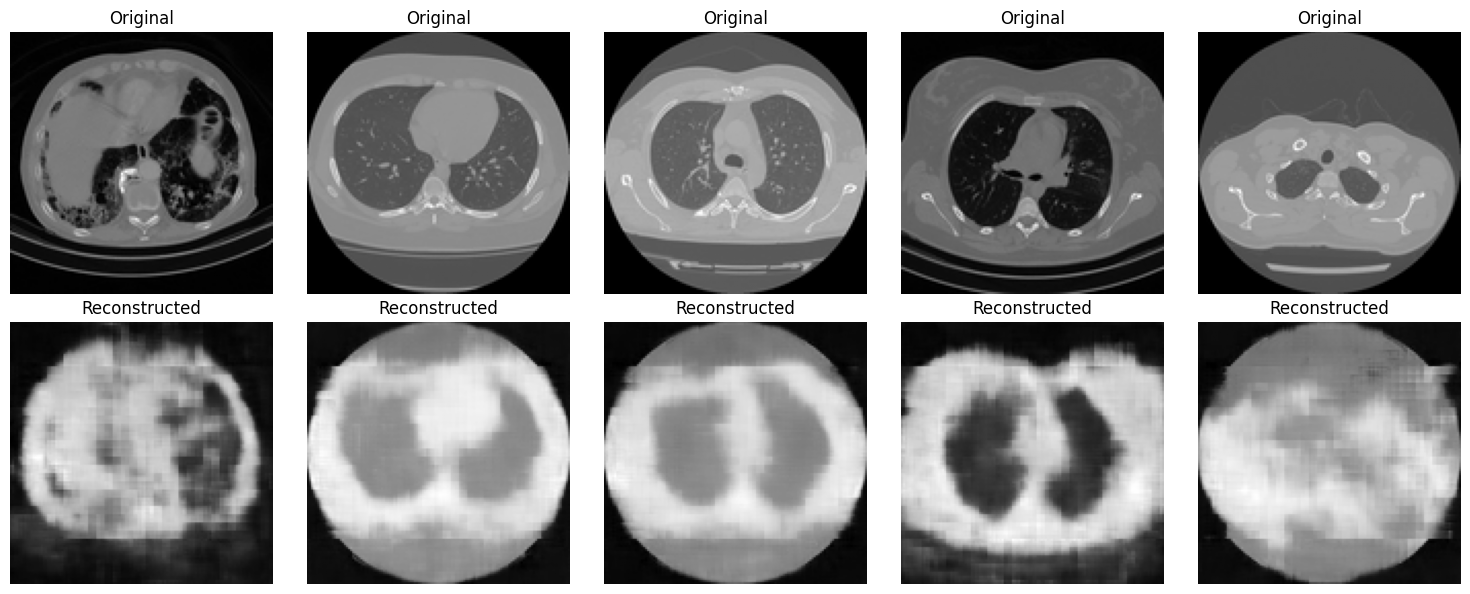

In [19]:
import matplotlib.pyplot as plt
import torch

def show_reconstructed_images(model, dataloader, device, num_images=5):
    model.eval()
    shown = 0
    with torch.no_grad():
        for sino, img in dataloader:
            sino = sino.to(device, non_blocking=True)
            img = img.to(device, non_blocking=True)

            output = model(sino)

            batch_size = img.size(0)
            n = min(batch_size, num_images - shown)

            # Create a figure with 2 rows: original and reconstructed
            fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(3 * n, 6))

            for i in range(n):
                # Original image
                axes[0, i].imshow(img[i].cpu().numpy().squeeze(), cmap="gray")
                axes[0, i].set_title("Original")
                axes[0, i].axis("off")

                # Reconstructed image
                axes[1, i].imshow(output[i].cpu().numpy().squeeze(), cmap="gray")
                axes[1, i].set_title("Reconstructed")
                axes[1, i].axis("off")

            plt.tight_layout()
            plt.show()

            shown += n
            if shown >= num_images:
                break

show_reconstructed_images(model, dataloader, device, num_images=5)
